In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
import pydicom as dcm
from glob import glob
import cv2, random

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau



from PIL import Image
import os
import glob

import warnings
warnings.filterwarnings('ignore')

In [28]:
import os

cwd_old = os.getcwd()
print('\nWorking Directory: ', cwd_old)

os.chdir('C:/Users/goods/Downloads/Neural Covid/COVID-19_Radiography_Dataset')
print('Working directory has been changed')

cwd_new = os.getcwd()
print('\nCurrent Working Directory: ', cwd_new)


Working Directory:  C:\Users\goods\Downloads\Neural Covid\COVID-19_Radiography_Dataset
Working directory has been changed

Current Working Directory:  C:\Users\goods\Downloads\Neural Covid\COVID-19_Radiography_Dataset


In [29]:
def load_image(image_path, size):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(size, size))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255.0
    return image

def load_images(paths, size, channels=3, num_images=10):
    images = []
    for path in paths[:num_images]:
        image = load_image(path, size)
        images.append(image)
    images = np.array(images)
    if channels == 1:
        images = np.expand_dims(images, axis=-1)
    return images

def display_img(image, title=None, cmap=None, alpha=1.0):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None: plt.title(title)
    plt.axis('off')

def display_m(image, mask, cmap='jet', alpha=0.2):
    show_image(image)
    show_image(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    


In [30]:
covid_dir = "C:/Users/goods/Downloads/Neural Covid/COVID-19_Radiography_Dataset/COVID"
normal_dir = "C:/Users/goods/Downloads/Neural Covid/COVID-19_Radiography_Dataset/Normal"

covid_image_path = os.path.join(covid_dir, "images")
covid_mask_path = os.path.join(covid_dir, "masks")
normal_image_path = os.path.join(normal_dir, "images")
normal_mask_path = os.path.join(normal_dir, "masks")

covid_image_paths = sorted(glob.glob(covid_image_path + '/*.png'))
covid_mask_paths = [path.replace('images','masks') for path in covid_image_paths]
normal_image_paths = sorted(glob.glob(normal_image_path + '/*.png'))
normal_mask_paths = [path.replace('images','masks') for path in normal_image_paths]

In [31]:
num_images = 500
covid_images = load_images(covid_image_paths, size=256, channels=3, num_images=num_images)
covid_masks = load_images(covid_mask_paths, size=256, channels=1, num_images=num_images)
normal_images = load_images(normal_image_paths, size=256, channels=3, num_images=num_images)
normal_masks = load_images(normal_mask_paths, size=256, channels=1, num_images=num_images)

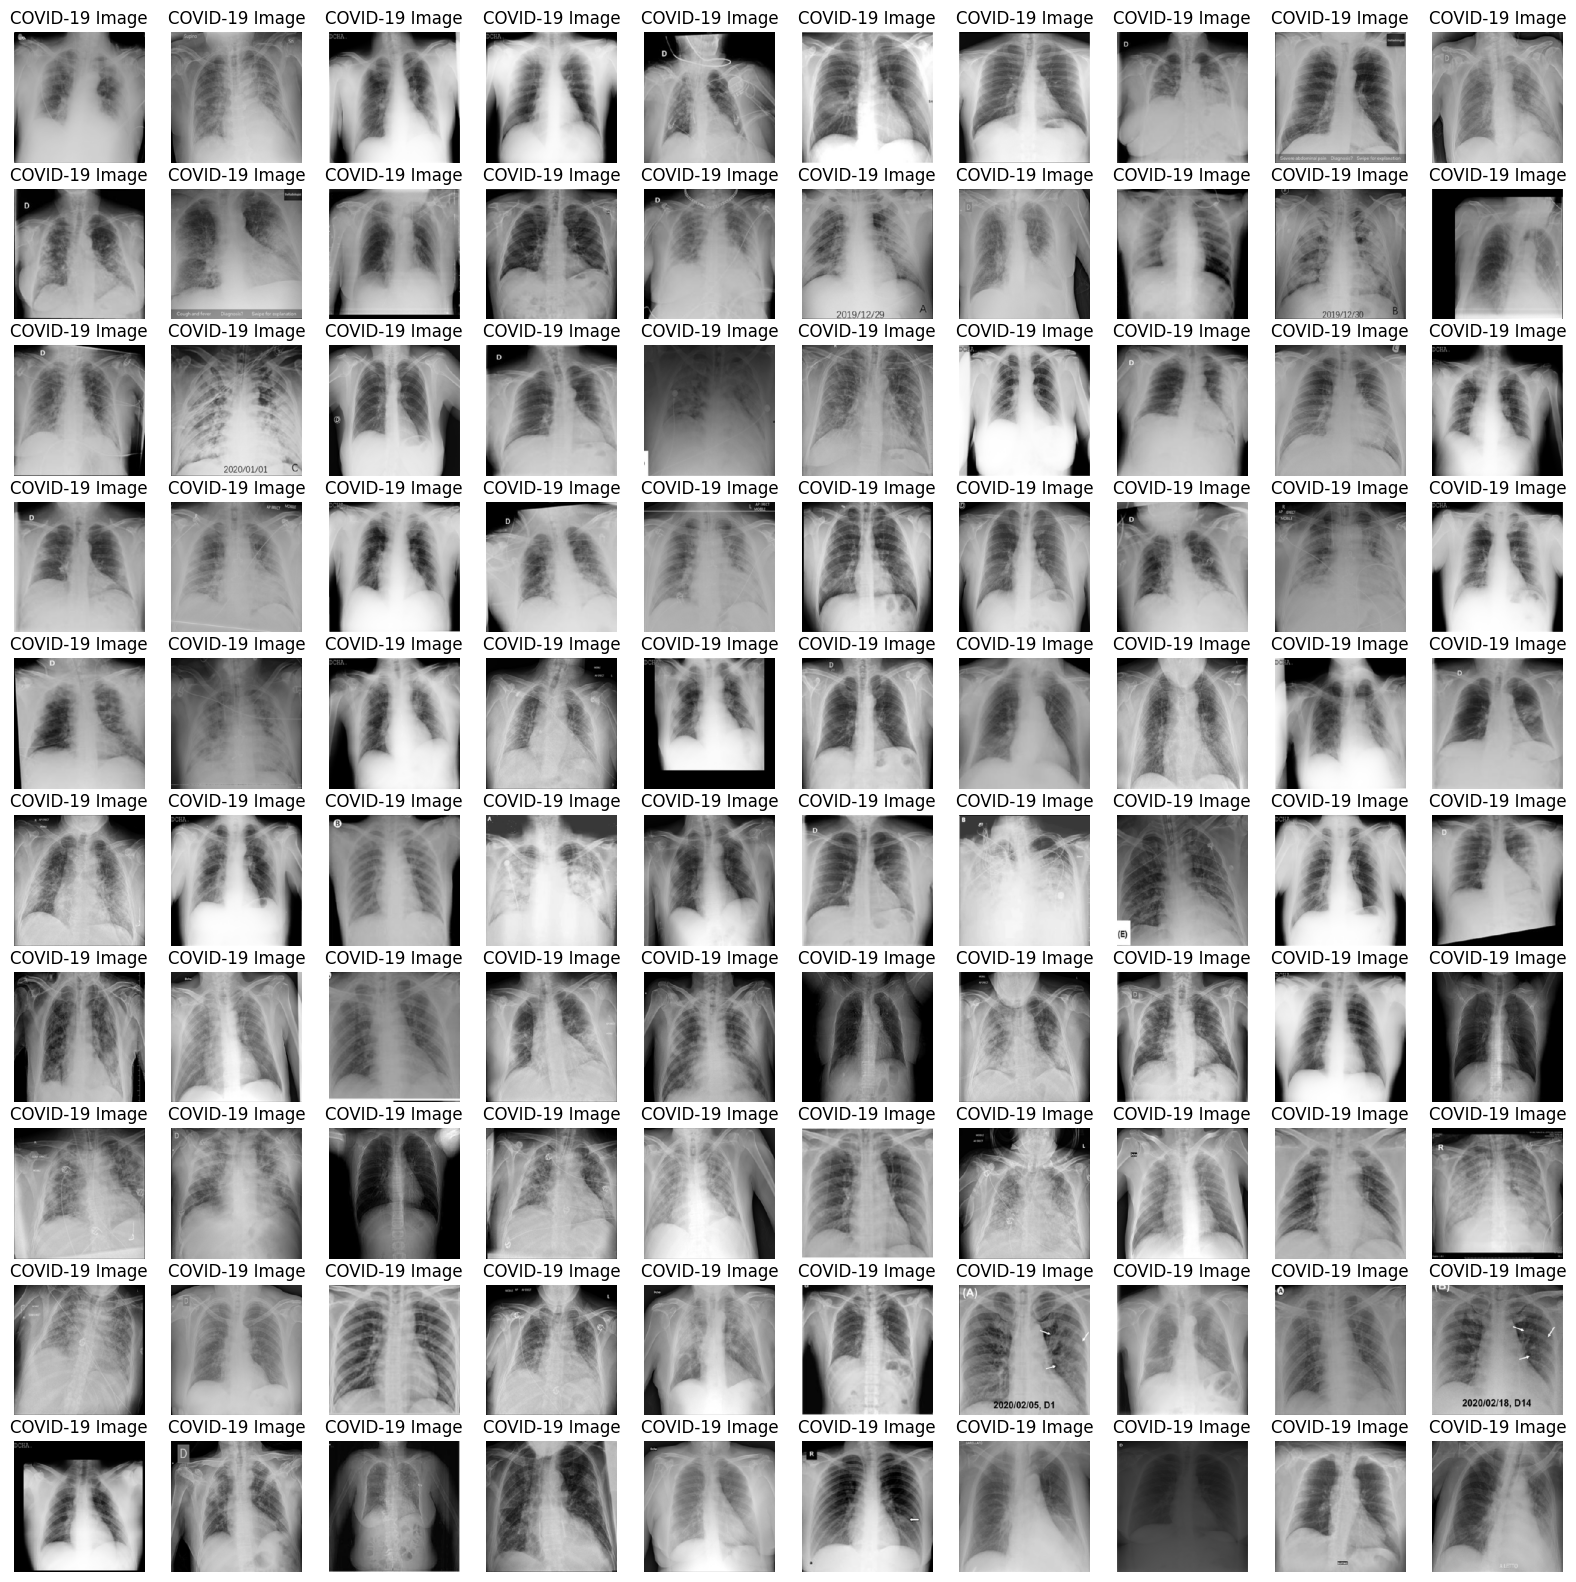

In [32]:
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20,20))
for i, ax in enumerate(axes.flat):
    ax.imshow(covid_images[i])
    ax.set_title("COVID-19 Image")
    ax.axis('off')
    
plt.show()

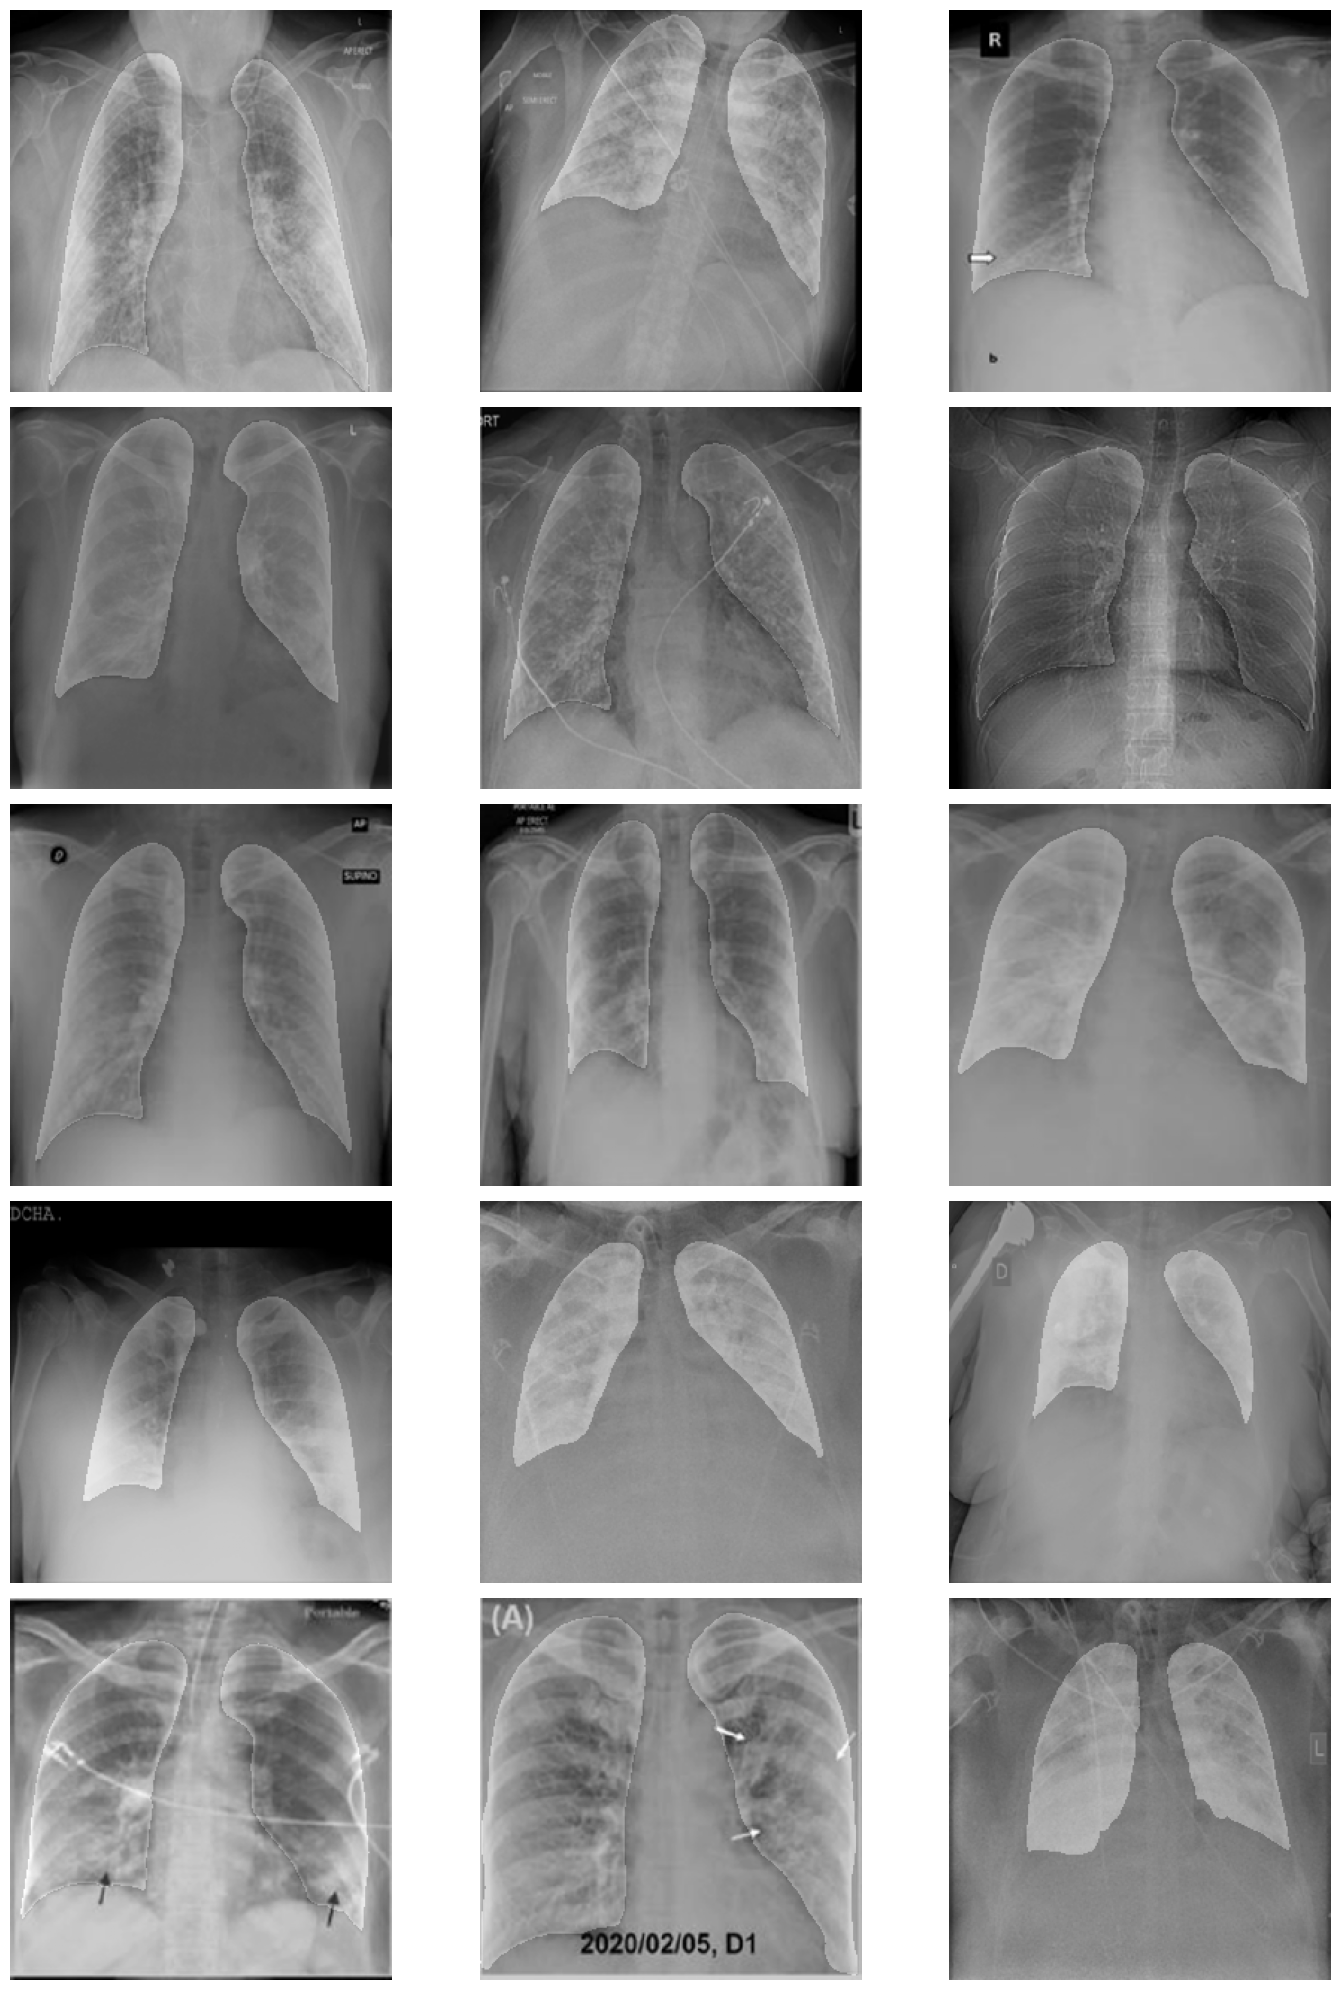

In [33]:
plt.figure(figsize=(15,20))
for i in range(1,16):
    plt.subplot(5,3,i)
    id = np.random.randint(len(covid_images))
    plt.imshow(covid_images[id])
    plt.imshow(tf.squeeze(covid_masks[id]), cmap='jet', alpha=0.2)
    plt.axis('off')
plt.tight_layout()
plt.show()

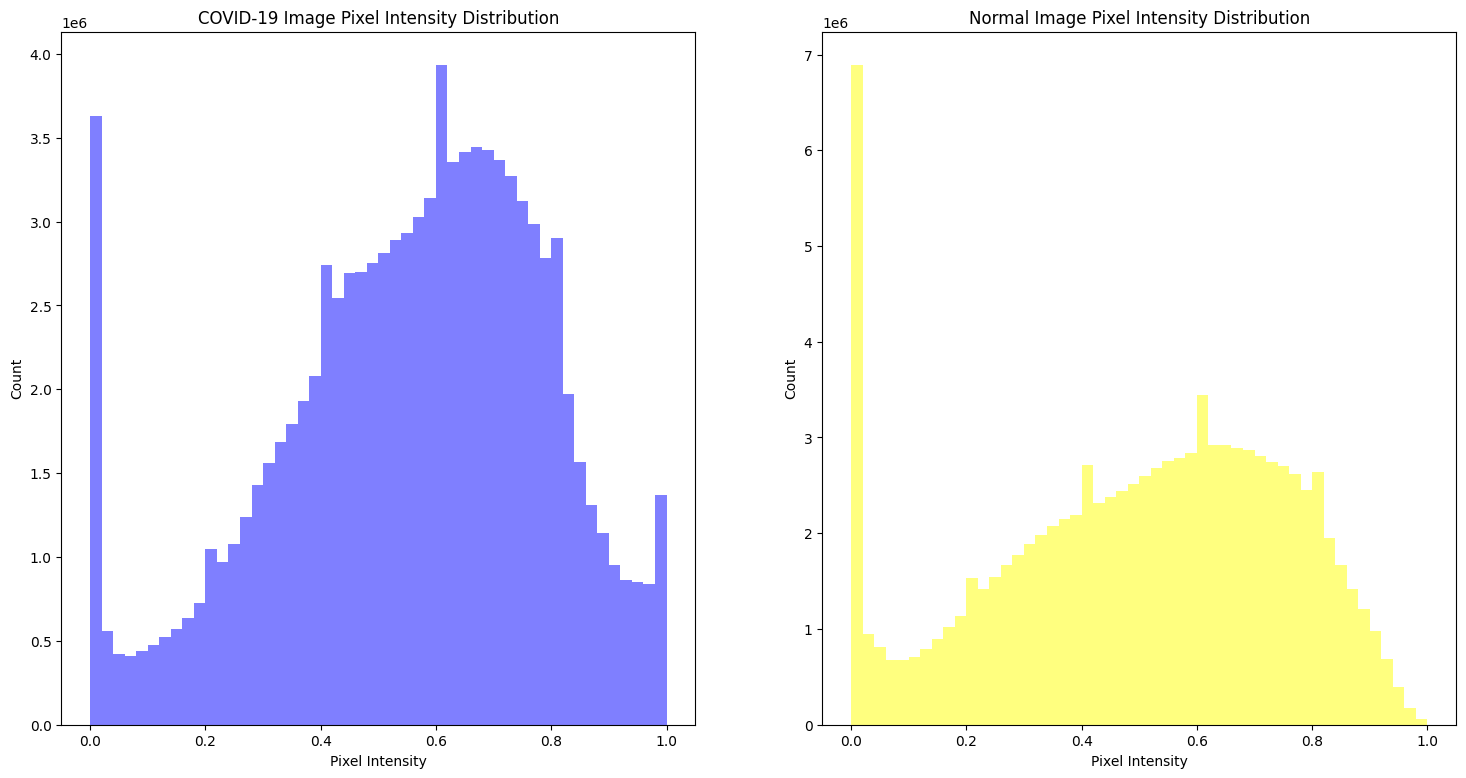

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,9))
axes[0].hist(covid_images.flatten(), bins=50, color='blue', alpha=0.5)
axes[0].set_title('COVID-19 Image Pixel Intensity Distribution')
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Count')
axes[1].hist(normal_images.flatten(), bins=50, color='yellow', alpha=0.5)
axes[1].set_title('Normal Image Pixel Intensity Distribution')
axes[1].set_xlabel('Pixel Intensity')
axes[1].set_ylabel('Count')
plt.show()

In [35]:
images = np.concatenate((covid_images, normal_images), axis=0)
masks = np.concatenate((covid_masks, normal_masks), axis=0)

In [36]:
labels = np.concatenate((np.zeros(len(normal_images)), np.ones(len(covid_images))))

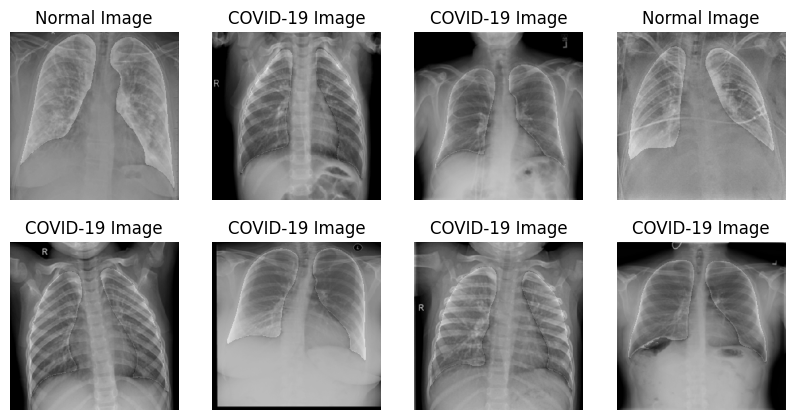

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10,5))
for i, ax in enumerate(axes.flat):
    if i < 8:
        rand = np.random.randint(len(images))
        ax.imshow(images[rand])
        ax.imshow(tf.squeeze(masks[rand]), cmap='jet', alpha=0.2)
        if labels[rand] == 0:
            ax.set_title("Normal Image")
        else:
            ax.set_title("COVID-19 Image")
        ax.axis('off')
plt.show()

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=30)

In [40]:
batch_size = 8
epochs = 40

In [41]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.1, horizontal_flip=True, vertical_flip=True)
generator = datagen.flow(X_train, y_train, batch_size=batch_size)
class_weight = {0: 1, 1: 5}
early_stop = EarlyStopping(monitor='val_loss', patience=3)


In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [43]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
history = model.fit(generator, epochs=epochs, validation_data=(X_test, y_test), batch_size=batch_size, class_weight=class_weight, callbacks=[early_stop])


Epoch 1/40
100/100 [==============================] - 7s 67ms/step - loss: 1.4265 - accuracy: 0.5813 - val_loss: 0.9629 - val_accuracy: 0.5700
Epoch 2/40
100/100 [==============================] - 7s 66ms/step - loss: 1.0672 - accuracy: 0.5425 - val_loss: 0.9384 - val_accuracy: 0.5500
Epoch 3/40
100/100 [==============================] - 7s 66ms/step - loss: 1.0497 - accuracy: 0.5288 - val_loss: 0.7559 - val_accuracy: 0.5450
Epoch 4/40
100/100 [==============================] - 7s 66ms/step - loss: 1.0783 - accuracy: 0.6237 - val_loss: 0.6804 - val_accuracy: 0.7350
Epoch 5/40
100/100 [==============================] - 6s 65ms/step - loss: 1.0356 - accuracy: 0.6525 - val_loss: 0.9268 - val_accuracy: 0.6200
Epoch 6/40
100/100 [==============================] - 7s 65ms/step - loss: 1.0096 - accuracy: 0.6500 - val_loss: 0.8970 - val_accuracy: 0.6350
Epoch 7/40
100/100 [==============================] - 7s 66ms/step - loss: 1.0446 - accuracy: 0.6725 - val_loss: 1.0154 - val_accuracy: 0.6350

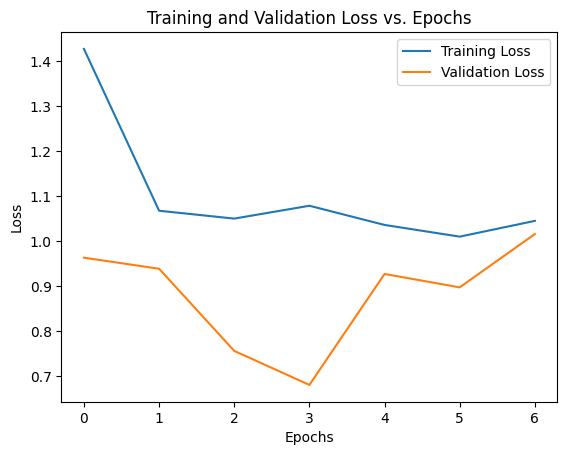

In [45]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

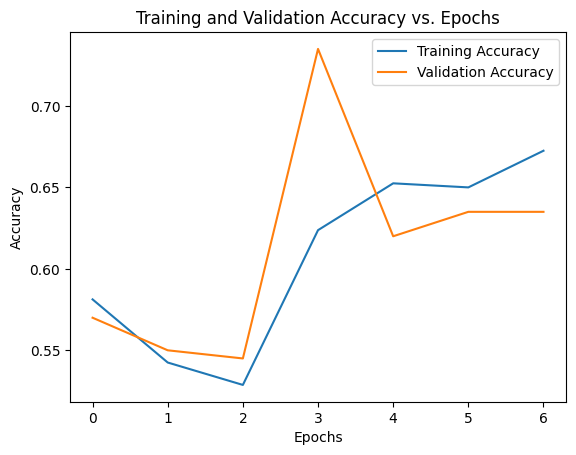

In [46]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [47]:
model1 = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [48]:
optimizer = Adam(lr=0.001)
model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
lr_ca = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=0.00001)

In [50]:
history1 = model1.fit(generator, validation_data=(X_test, y_test), epochs=50, callbacks=[lr_ca])

Epoch 1/50
100/100 [==============================] - 7s 66ms/step - loss: 0.6866 - accuracy: 0.6275 - val_loss: 0.6057 - val_accuracy: 0.6950
Epoch 2/50
100/100 [==============================] - 7s 66ms/step - loss: 0.5835 - accuracy: 0.7563 - val_loss: 0.6240 - val_accuracy: 0.6850
Epoch 3/50
100/100 [==============================] - 6s 65ms/step - loss: 0.5446 - accuracy: 0.7700 - val_loss: 0.6092 - val_accuracy: 0.6850
Epoch 4/50
100/100 [==============================] - 7s 65ms/step - loss: 0.5243 - accuracy: 0.7675 - val_loss: 0.5840 - val_accuracy: 0.6950
Epoch 5/50
100/100 [==============================] - 6s 64ms/step - loss: 0.5138 - accuracy: 0.7688 - val_loss: 0.5973 - val_accuracy: 0.6950
Epoch 6/50
100/100 [==============================] - 7s 65ms/step - loss: 0.4999 - accuracy: 0.7775 - val_loss: 0.5603 - val_accuracy: 0.6950
Epoch 7/50
100/100 [==============================] - 6s 65ms/step - loss: 0.4735 - accuracy: 0.7837 - val_loss: 0.6576 - val_accuracy: 0.6950

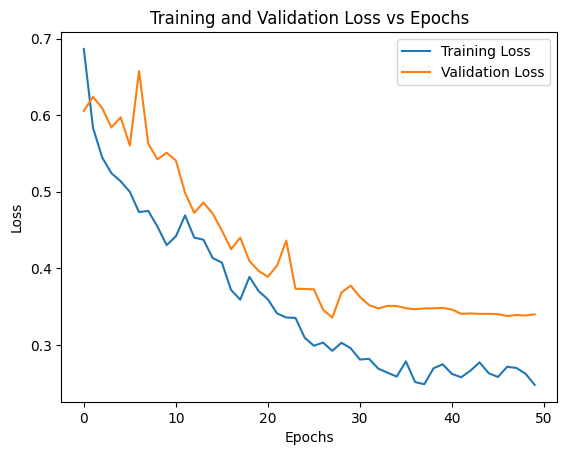

In [51]:
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.legend()
plt.show()

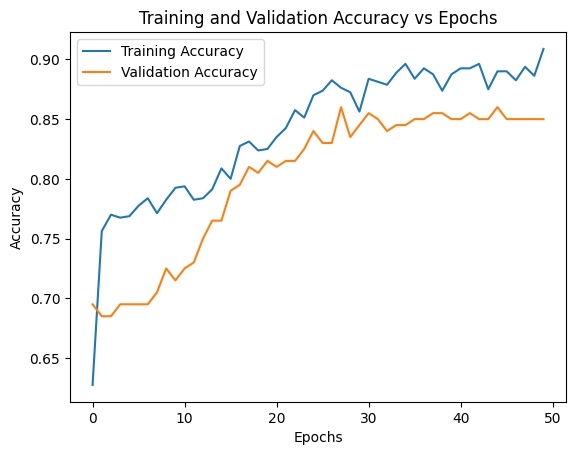

In [52]:
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Epochs')
plt.legend()
plt.show()

In [54]:
lr_values = []
for i in range(len(history1.history['lr'])):
    lr_values.append(optimizer.lr.numpy())

In [53]:
lrs = lr_ca.get_lr()
plt.plot(lrs)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate vs Epochs')
plt.show()

AttributeError: 'ReduceLROnPlateau' object has no attribute 'get_lr'

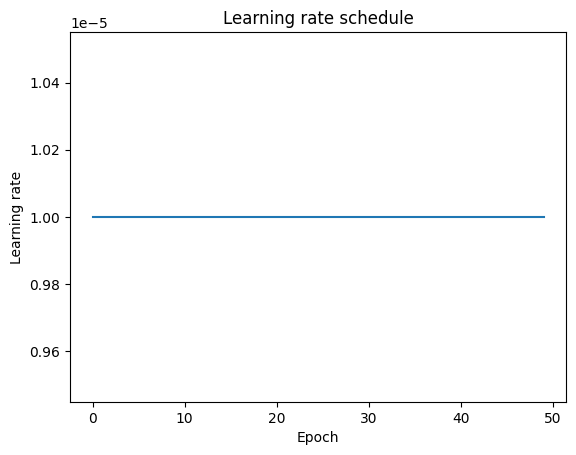

In [55]:
plt.plot(lr_values)
plt.title('Learning rate schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.show()

## Grid and random search for hyper parameter tuning giving errors.